In [1]:
import os
import librosa
import librosa.display
import pickle
from sphfile import SPHFile
from pathlib import Path
from tqdm import tqdm
from random import choice, randint
import numpy as np
from matplotlib import pyplot as plt
import soundfile

BASE_DIR = Path(os.getcwd()).parent
DATA_DIR = BASE_DIR / 'data'

In [2]:
# STFT ---------------------
def compute_stft(audio_data, win_length=2048, hop_length=512, n_fft=2048):
    '''
    Helper method to compute the Short Time Fourier Transform
    '''
    return librosa.stft(audio_data, win_length=win_length, hop_length=hop_length, n_fft=n_fft)

In [14]:
def plot_spectrogram(stft, title = "Spectrogtam"):
    fig, ax = plt.subplots(figsize = (10,5))
    img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft), ref=np.max), y_axis='log', x_axis='time', ax=ax)
    ax.set_title(title)
    fig.colorbar(img, ax=ax, format="%+2.0f dB")

In [4]:
split = 'train'

In [5]:
noise_list = open(os.path.join(DATA_DIR, 'noise_list.txt')).readlines()
file_list = open(os.path.join(DATA_DIR, '%s_set.txt'%(split))).readlines()

In [6]:
num_samples = 1
alpha = 0.8
k = 512

In [7]:
signal_len_lst = []
clean_mixed_data_dict = {}
clean_mixed_data_dict['clean'] = []
clean_mixed_data_dict['mixed'] = []
itr = 0
while len(signal_len_lst) < num_samples and itr < len(file_list):
    snr = choice((15,20)) # randomly sample snr from 15-20
    sph_data = SPHFile(os.path.join(BASE_DIR, file_list[itr]).rstrip())
    itr += 1
    samp_rate = sph_data.format['sample_rate']

    # Randomly sample noise sample from noise data list
    noise_data = librosa.load(os.path.join(BASE_DIR, choice(noise_list)).rstrip(), sr=samp_rate)
    assert(noise_data[1] == samp_rate == 16000)
    noise_signal = noise_data[0]

    # Mixing noise with clean speech
    clean_signal = sph_data.content / (2**(sph_data.format['sample_sig_bits'] - 1))

    len_signal = min(clean_signal.shape[0], noise_signal.shape[0])
    if len_signal/k < 64: continue
    print(len_signal/k, snr)
    signal_len_lst.append(len_signal)

    start_n = randint(0, max(0, noise_signal.shape[0] - clean_signal.shape[0]))

    # randomly sample a window from noise sequence to be mixed
    noise_signal = noise_signal[start_n:start_n+len_signal]
    clean_signal = clean_signal[0:len_signal]

    p_noise = np.average(noise_signal**2)
    p_signal = np.average(clean_signal**2)
    alpha = np.sqrt(p_signal/p_noise * 10**-(snr/10))

    mixed_signal = clean_signal + alpha * noise_signal

    stft_clean = compute_stft(clean_signal, win_length=k, n_fft=k)
    stft_mixed = compute_stft(mixed_signal, win_length=k, n_fft=k)

    clean_mixed_data_dict['clean'].append(stft_clean)
    clean_mixed_data_dict['mixed'].append(stft_mixed)

112.552734375 15


In [9]:
signal_len_lst, stft_clean.shape, alpha

([57627], (257, 113), 0.1991974943744616)

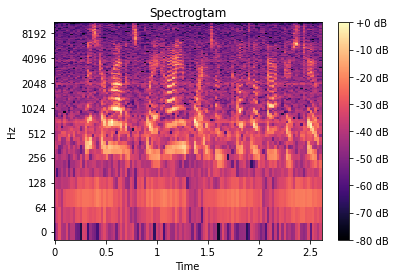

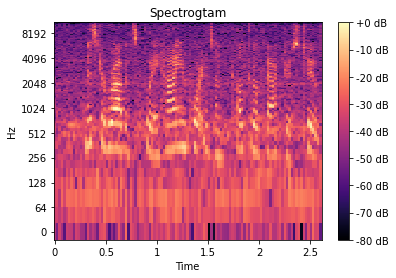

In [10]:
plot_spectrogram(stft_clean)
plot_spectrogram(stft_mixed)

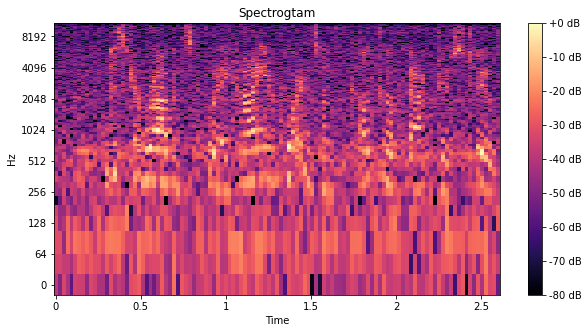

In [19]:
plot_spectrogram(np.real(stft_mixed))

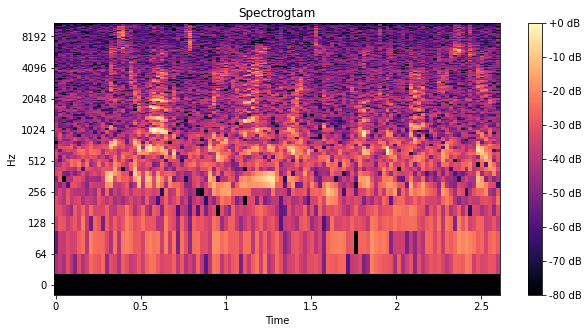

In [20]:
plot_spectrogram(np.imag(stft_mixed))

In [85]:
soundfile.write('test_pk_n.wav', mixed_signal, samp_rate)
soundfile.write('test_pk_c.wav', clean_signal, samp_rate)

In [114]:
stft_clean

array([[-3.14483688e-02+0.00000000e+00j,  2.76261325e-02+0.00000000e+00j,
         1.06834098e-01+0.00000000e+00j, ...,
        -1.16363635e-01+0.00000000e+00j,  2.16687609e-02+0.00000000e+00j,
        -5.38264841e-02+0.00000000e+00j],
       [ 4.52396746e-02+7.21848194e-03j,  2.35334677e-02-1.75520033e-03j,
        -5.08306451e-02+2.52592261e-02j, ...,
         1.25365650e-01+5.36845014e-02j, -3.43279990e-02+3.61270016e-02j,
         4.02959493e-02-8.54283854e-03j],
       [-5.97319485e-02+1.69973855e-02j, -7.27756721e-02-6.73816255e-03j,
        -3.91538644e-02+3.41808798e-02j, ...,
        -6.11524404e-02-6.58253099e-02j,  2.66236952e-02-2.65036764e-02j,
        -4.09656218e-02+1.75096592e-02j],
       ...,
       [-1.15941161e-03-1.44365790e-05j,  1.05316205e-04-1.31320523e-04j,
        -3.25055105e-05-4.89029091e-04j, ...,
        -2.81202306e-04+2.14384051e-04j,  6.21580569e-05+1.12710744e-04j,
        -3.00990935e-04-1.00568923e-04j],
       [ 1.12186172e-03+4.67549368e-05j,  9.

In [118]:
np.real(stft_clean)

array([[-3.14483688e-02,  2.76261325e-02,  1.06834098e-01, ...,
        -1.16363635e-01,  2.16687609e-02, -5.38264841e-02],
       [ 4.52396746e-02,  2.35334677e-02, -5.08306451e-02, ...,
         1.25365650e-01, -3.43279990e-02,  4.02959493e-02],
       [-5.97319485e-02, -7.27756721e-02, -3.91538644e-02, ...,
        -6.11524404e-02,  2.66236952e-02, -4.09656218e-02],
       ...,
       [-1.15941161e-03,  1.05316205e-04, -3.25055105e-05, ...,
        -2.81202306e-04,  6.21580569e-05, -3.00990935e-04],
       [ 1.12186172e-03,  9.07823442e-05,  2.16911362e-05, ...,
         8.79789142e-05, -3.22898033e-05,  3.31494357e-04],
       [-1.17743399e-03, -1.74596341e-04,  1.44004042e-04, ...,
         6.59608839e-05, -9.24206188e-05, -2.84587791e-04]])

In [119]:
np.imag(stft_clean)

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.21848194e-03, -1.75520033e-03,  2.52592261e-02, ...,
         5.36845014e-02,  3.61270016e-02, -8.54283854e-03],
       [ 1.69973855e-02, -6.73816255e-03,  3.41808798e-02, ...,
        -6.58253099e-02, -2.65036764e-02,  1.75096592e-02],
       ...,
       [-1.44365790e-05, -1.31320523e-04, -4.89029091e-04, ...,
         2.14384051e-04,  1.12710744e-04, -1.00568923e-04],
       [ 4.67549368e-05,  1.75218988e-04,  4.34652151e-04, ...,
        -2.91571950e-04, -1.79106266e-04,  2.63615245e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])